<a id='intro'></a>
# Описание проекта 

Необходимо провести исследование клиентов банка и выделить сегменты,
которые склонны уходить из банка.

# Описание данных

Предоставлен датафрейм с данными клиентов банка.<br>

Структура данных:  

- USERID — идентификатор пользователя;
- score — баллы кредитного скоринга (определяется банком на основании скоринговой системы, чем выше определена кредитоспособность клиента, тем выше балл);
- city — город;
- gender — пол;
- age — возраст;
- equity — количество баллов собственности (определяется в зависимости от наличия в собственности клиента какого-либо имущества следующим образом: 1 имущество - 1 балл);
- balance — баланс на счёте;
- products — количество продуктов, которыми пользуется клиент;
- credit_card — есть ли кредитная карта (1 - у клиента есть кредитная карта, 0 - у клиента отсутствует кредитная карта);
- last_activity — активный клиент (определяется на основании установленного банком временного периода после проведения последнего действия клиента: 1- активный клиент, 0 - клиент не активен);
- EST_SALARY — оценочный доход клиента;
- сhurn — признак оттока (1 - клиент ушел, 0 - клиент не ушел)

# План действий:

[1. Загрузка и ознакомление с данными](#загрузка) <br>
[2. Предобработка данных](#предобработка) <br>
[3. Исследовательский анализ данных](#EDA) <br>
[4. Проверка статистических гипотез](#hypothesis) <br>
[5. Сегментация](#segmentation) <br>
[6. Вывод](#conclusions) <br>
[7. Рекомендации](#recommendations) <br>

## Установка модулей

In [1]:
!pip3 install sidetable
!pip3 install phik
!pip3 install missingno
!pip install -U kaleido

## Импорт библиотек

In [2]:
import pandas as pd

import numpy as np

import os

import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

import plotly.express as px
from plotly import graph_objects as go

import math as mth

import sidetable as stb

from scipy import stats as st

import phik

import missingno as msno

<a id='загрузка'></a>
## Загрузка и ознакомление с данными

### Загрузка данных

In [3]:
pth_1 = '/datasets/bank_scrooge.csv'
pth_2 = 'https://code.s3.yandex.net/datasets/bank_scrooge.csv'

if os.path.exists(pth_1):
    df = pd.read_csv(pth_1)
elif os.path.exists(pth_2):
    df = pd.read_csv(pth_2)
else:
    print('Проверьте правильность пути к датафрейму')

### Ознакомление с данными

In [4]:
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Названия ряда столбцов не соответствуют стилистике pandas.

[в начало](#intro)

<a id='предобработка'></a>
## Предобработка данных

### Общая информация о датафрейме

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Датафрейм содержит 12 столбцов и 10 000 строк.  
В некоторых столбцах есть пропуски.  
Названия столбцов USERID, EST_SALARY не соответствуют стилистике пандас. 
Тип данных у 6 столбцов (int64), у 4-х столбцов (float64), у 2-х (object).  
Отметим, что у столбца age (и, возможно, столбца score) с целочисленными значениями тип данных float64. 

### Изменение наименования столбцов

Приведем все названия столбцов к нижнему регистру и добавим змеиный регистр к столбцу с идентификатором клиента.

In [6]:
df.columns = df.columns.str.lower()
df.rename(columns={'userid':'user_id'}, inplace=True)

In [7]:
list(df)

['user_id',
 'score',
 'city',
 'gender',
 'age',
 'equity',
 'balance',
 'products',
 'credit_card',
 'last_activity',
 'est_salary',
 'churn']

После внесенных изменений названия столбцов соответствуют стилистике pandas.

### Проверка на нетипичные значения, которые не соответствуют описанию данных датафрейма

**Проверим наличие отрицательных значений в столбцах с числовыми значениями.**  

Cоздадим функцию, которая в каждом столбце с числовыми значениями будет находить количество отрицательных значений.

In [8]:
def minus_values(df):
    columns_num = (
    df.select_dtypes(include=['int64']).columns.tolist() 
    + df.select_dtypes(include=['float64']).columns.tolist()
    ) 
    
    for column in columns_num:
        print('Количество отрицательных значений в {}'.format(column),
              df[df[column] < 0][column].count())

In [9]:
minus_values(df)

Количество отрицательных значений в user_id 0
Количество отрицательных значений в equity 0
Количество отрицательных значений в products 0
Количество отрицательных значений в credit_card 0
Количество отрицательных значений в last_activity 0
Количество отрицательных значений в churn 0
Количество отрицательных значений в score 0
Количество отрицательных значений в age 0
Количество отрицательных значений в balance 0
Количество отрицательных значений в est_salary 0


Отрицательные значения отсутствуют.

**Посмотрим уникальные значения в столбцах city, gender, credit_card, last_activity, churn.**

In [10]:
column_uniq = ['city', 'gender', 'credit_card', 'last_activity', 'churn']

for column in column_uniq:
        print('Уникальные значения в столбце {}'.format(column),
              df[column].unique().tolist())

Уникальные значения в столбце city ['Рыбинск', 'Ярославль', 'Ростов']
Уникальные значения в столбце gender ['Ж', 'М']
Уникальные значения в столбце credit_card [0, 1]
Уникальные значения в столбце last_activity [1, 0]
Уникальные значения в столбце churn [1, 0]


В столбцах находятся только значения в соответствии с описанием данных датафрейм.

### Проверка наличия пропусков

In [11]:
df.stb.missing()

,missing,total,percent
balance,2295,10000,22.95
age,26,10000,0.26
user_id,0,10000,0.00
score,0,10000,0.00
city,0,10000,0.00
gender,0,10000,0.00
equity,0,10000,0.00
products,0,10000,0.00
credit_card,0,10000,0.00
last_activity,0,10000,0.00


В столбцах balance и age присутствуют пропуски, доля которых соответственно составляет 22.95% и 0.26%.  


Построим матрицу пропущенных значений, чтобы посмотреть наличие в пропусках какой-либо закономерности.

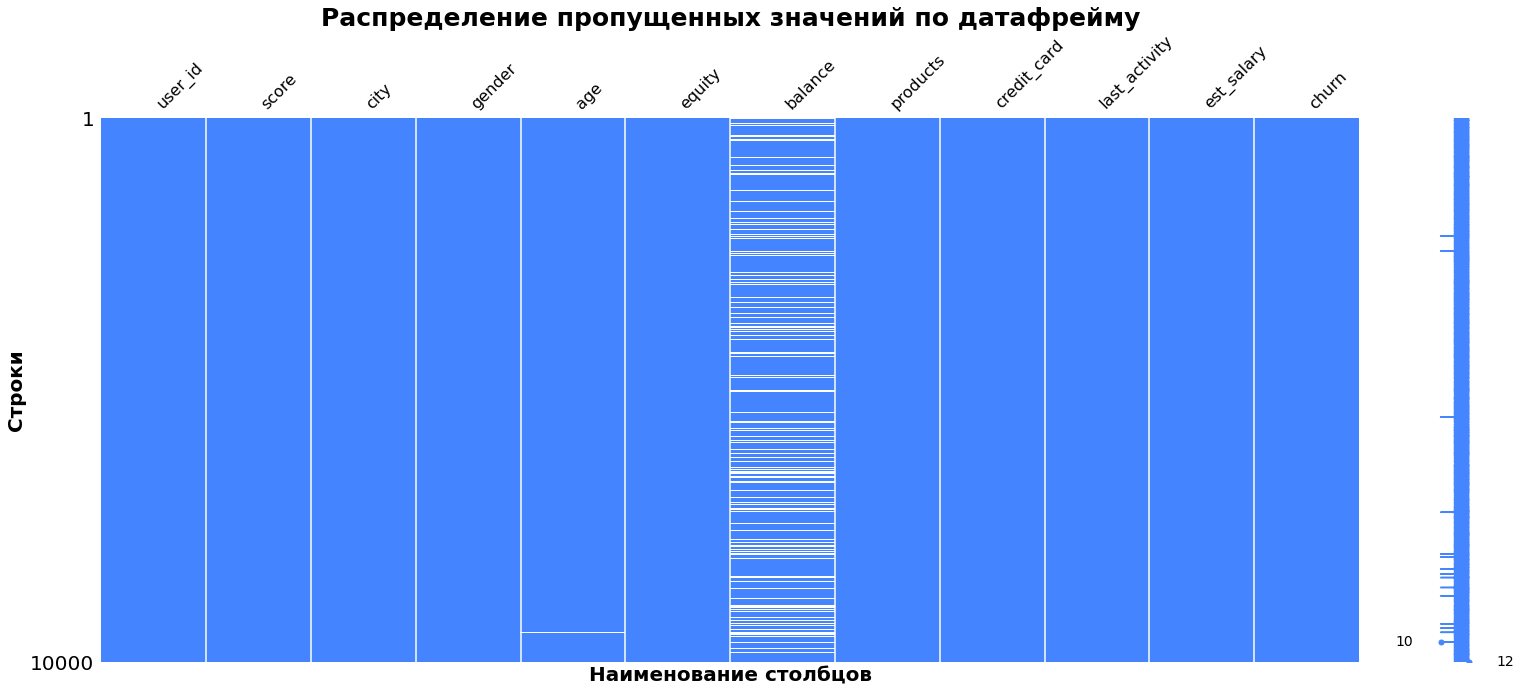

In [12]:
msno.matrix(df, color=(0.27, 0.52, 1.0));

plt.title('Распределение пропущенных значений по датафрейму', fontsize=25, fontweight="bold")
plt.xlabel('Наименование столбцов', fontsize=20, fontweight="bold")
plt.ylabel('Строки', fontsize=20, fontweight="bold");
plt.show();

Распределение пропущенных значений в датафрейме выглядит случайным:
- пропущенные значения в столбце 'age' наблюдается в единственном месте
- пропущенные значения в столбце 'balance' распределены равномерно по всему столбцу

Построим матрицу корреляции пропущенных значений, которая показывает насколько сильно присутствие или отсутствие значений одного признака влияет на присутствие значений другого. 

In [13]:
round(df[['age', 'balance']].isna().corr(), 3)

,age,balance
age,1.000,0.047
balance,0.047,1.000


Корреляция пропусков близка к нулю, т.е. пропуски одного признака не влияют на пропуски другого.

Поскольку исследование проводится на предмет оттока клиентов, посмотрим количество ушедших клиентов в столбцах age и balance которых отсутствуют значения.

In [14]:
print('количество ушедших клиентов в столбце c пропусками age', \
      len(df.query('age.isna() == True and churn == 1')))

print('количество ушедших клиентов в столбце c пропусками balance', \
      len(df.query('balance.isna() == True and churn == 1')))

количество ушедших клиентов в столбце c пропусками age 1
количество ушедших клиентов в столбце c пропусками balance 13


Обработаем пропуски следующим образом:  
- удалим строки с пропусками в столбце age, поскольку доля пропусков незначительная (0.26%) и существенной потери данных не будет.
- пропуски в столбце balance оставим без изменения, поскольку доля пропусков значительна (почти 23%) и при удалении либо заполнении какими-либо 'синтетическими' данными, возможно, в дальнейшем приведет к искажению результатов. 

Удалим строки с пропусками в столбце age и сбросим индексы.

In [15]:
df.dropna(subset = ['age'], inplace = True)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9974 entries, 0 to 9973
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9974 non-null   int64  
 1   score          9974 non-null   float64
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   float64
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 935.2+ KB


Осталось 9974 строк.

### Изменение типа данных

Посмотрим тип данных у всех признаков.

In [16]:
df.dtypes

user_id            int64
score            float64
city              object
gender            object
age              float64
equity             int64
balance          float64
products           int64
credit_card        int64
last_activity      int64
est_salary       float64
churn              int64
dtype: object

Проверим столбец score и age, возможно, значения в столбах являются не вещественными, а целочисленными. 

Для этого создадим функцию, которая после проверки дробной части значений столбца, не являющихся пропусками, на выходе будет выдавать являются ли значения вещественными либо целочисленными.  

In [17]:
def isWhole(column):
    for i in df[df[column].notna()][column]:
        if i%1 != 0:
            return print('в столбце вещественные значения')
    return print('в столбце все значения целочисленные')

In [18]:
isWhole('score')
print()
isWhole('age')

в столбце все значения целочисленные

в столбце все значения целочисленные


Изменим тип данных в столбцах age и score на целочисленный.

In [19]:
df[['age', 'score']] = df[['age', 'score']].astype(float).astype('int64')

df[['age', 'score']].dtypes

age      int64
score    int64
dtype: object

### Проверка аномалий и редких значений в столбцах balance, est_salary, age, products

In [20]:
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


Создадим функцию, которая будет выводить описательную статистику и график ящик с усами.

In [21]:
def describe_attr(attribute):
    
    # описательная статистика
    print('Описательная статистика для значений {}:'.format(attribute) + '\n', 
          round(df[attribute].describe()))
    
    # ящик с усами
    plt.figure(figsize=(15,2))
    sns.boxplot(x=attribute, data=df)

    plt.title('Распределение значений {}'.format(attribute), fontsize=20, fontweight="bold")
    plt.xlabel('{}'.format(attribute), fontsize=14, fontweight="bold")
    plt.ylabel('', fontsize=14, fontweight="bold");
    plt.show();

Посмотрим описательную статистику и построим график ящик с усами для age.

Описательная статистика для значений age:
 count    9974.0
mean       43.0
std        12.0
min        18.0
25%        33.0
50%        40.0
75%        51.0
max        86.0
Name: age, dtype: float64


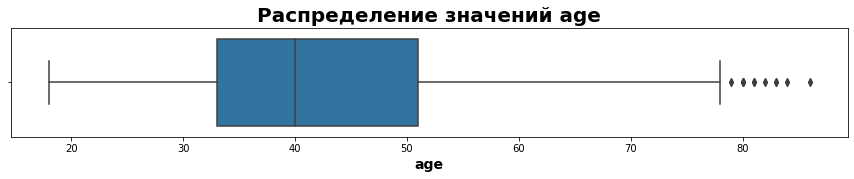

In [22]:
describe_attr('age')

Клиенты в зависимости от возраста, лет:
- большинство клиентов возрастом от 33 до 51
- средний возраст 43
- медиана - 40
- минимальный - 18
- максимальный - 86 
- клиенты старше ~ 77 лет встречаются редко

Посмотрим описательную статистику и построим график ящик с усами для balance.

Описательная статистика для значений balance:
 count         7695.0
mean        827246.0
std        1980327.0
min              0.0
25%         295699.0
50%         524295.0
75%         980051.0
max      119113552.0
Name: balance, dtype: float64


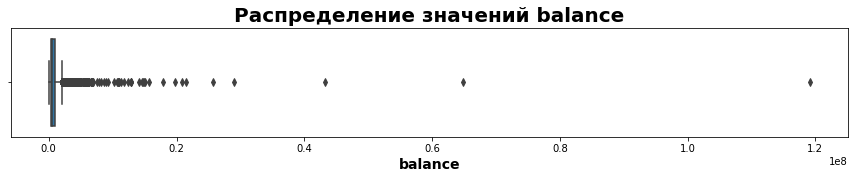

In [23]:
describe_attr('balance')

Клиенты в зависимости от баланса:

- большинство клиентов с балансом от 295 тыс.до 980 тыс.
- среднее значение - ~ 830 тыс.
- медиана - ~ 525 тыс.
- минимальный - 0
- максимальный - 119 113 тыс.
- клиенты с балансом более являются редкими 20 000 тыс., но не являются аномалиями.

Посмотрим описательную статистику по уровню дохода

Описательная статистика для значений est_salary:
 count       9974.0
mean      147787.0
std       139286.0
min         2546.0
25%        75252.0
50%       119627.0
75%       174500.0
max      1395064.0
Name: est_salary, dtype: float64


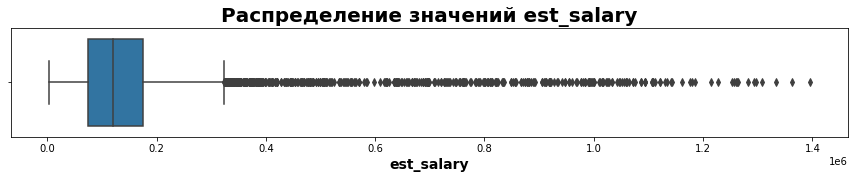

In [24]:
describe_attr('est_salary')

Клиенты в зависимости от дохода:

- большинство клиентов с доходом от 75 тыс.до 175 тыс.
- среднее значение - ~ 148 тыс.
- медиана - ~ 175 тыс.
- минимальный - 2,5 тыс.
- максимальный - 1 395 тыс.
- клиенты с балансом более ~320 тыс. встречаются реже, но не являются аномалиями

Посмотрим описательную статистику и построим график ящик с усами для products.

Описательная статистика для значений products:
 count    9974.0
mean        2.0
std         1.0
min         0.0
25%         1.0
50%         2.0
75%         2.0
max         5.0
Name: products, dtype: float64


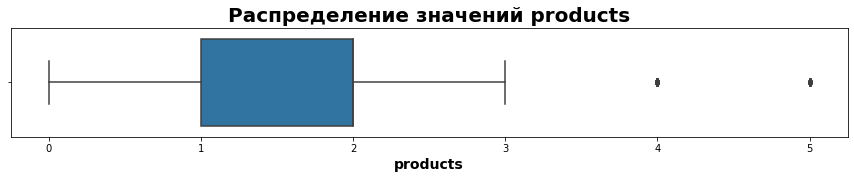

In [25]:
describe_attr('products')

In [26]:
df.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8939,147837,962,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1


В банке один клиент без оформленных продуктов, что является аномалией.  
Кроме того, у данного клиента отсутствует значение баланса, а также возраст 79, входящий в границу редких значений по возрасту. 
Удалим данное аномальное значение.

In [27]:
df = df.query('products != 0').reset_index(drop=True)
df.shape

(9973, 12)

### Проверка наличия дубликатов

Проверим наличие явных дубликатов.

In [28]:
df.duplicated().sum()

0

Явные дубликаты отсутствуют.

Проверим наличие неявных дубликатов по столбцу user_id.

In [29]:
df['user_id'].duplicated().sum()

50

В столбце user_id встречаются 50 одинкаовых id.

Посмотрим встречаются ли дубликаты по user_id и city.

In [30]:
df[['user_id', 'city']].duplicated().sum()

0

В датафрейме отсутствуют записи с одинаковыми значениями в столбцах user_id и city.

Посмотрим встречаются ли дубликаты по user_id и churn.

In [31]:
df[['user_id', 'churn']].duplicated().sum()

0

Дубликаты отсутствуют.

Посмотрим встречаются ли дубликаты по user_id и age.

In [32]:
df[['user_id', 'age']].duplicated().sum()

5

В датафрейме 10 записей с одинаковыми значениями в столбцах user_id и age.  
Посмотрим данные записи.

In [33]:
df.loc[df.duplicated(subset=['user_id','age'], keep = False)].sort_values(by='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5247,148826,895,Ярославль,М,32,5,1470273.14,2,0,0,118058.52,1
8350,148826,909,Рыбинск,Ж,32,0,NaN,3,1,0,28843.54,0
3270,155765,863,Ярославль,М,30,5,1036114.50,5,1,1,150744.50,1
5192,155765,923,Рыбинск,М,30,0,NaN,1,1,1,120296.60,0
3560,163207,853,Рыбинск,М,42,4,543839.62,1,1,1,105281.97,1
6779,163207,838,Ярославль,Ж,42,4,652776.60,2,1,1,97545.36,0
1358,211130,833,Ярославль,М,55,3,1231184.90,4,0,1,187758.38,1
3813,211130,918,Рыбинск,Ж,55,0,NaN,2,1,1,244202.04,0
8192,227795,840,Рыбинск,М,34,2,350768.03,1,1,0,102036.14,1
8481,227795,839,Ярославль,М,34,2,326593.14,2,1,0,103314.92,0


Как видно из среза данных, одинаковые id могут быть как у клиентов мужского пола так и у клиентов женского пола.  
Исходя из вышенаписанного, нельзя сделать предположение, что записи с одинаковым id, возрастом и полом являются дубликатами.  
Таким образом, наличие совпадения по user_id не является признаком дублирования. 

### Добавим столбец, который будет отображать статусы клиента 

Создадим функцию, которые будут выдавать статус клиента в зависимости от параметра.

In [34]:
# для churn
def replace_param_ch(param):
    if param == 0:
        return 'не отток'
    else:
        return 'отток'

In [35]:
# для credit_card
def replace_param_cr(param):
    if param == 0:
        return 'не оформлена'
    else:
        return 'оформлена'

In [36]:
# для last_activity
def replace_param_act(param):
    if param == 0:
        return 'не активный'
    else:
        return 'активный'

Создадим столбы customer_churn, cred_card, activity.

In [37]:
df['customer_churn'] = df['churn'].apply(replace_param_ch)
df['cred_card'] = df['credit_card'].apply(replace_param_cr)
df['activity'] = df['last_activity'].apply(replace_param_act)

#### Изменим значения в столбце gender, credit_card и last_activity

In [38]:
df['gender'] = df['gender'].replace(['М', 'Ж'],['мужской', 'женский'])

Посмотрим внесенные изменения.

In [39]:
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,customer_churn,cred_card,activity
0,183012,850,Рыбинск,женский,25,1,59214.82,2,0,1,75719.14,1,отток,не оформлена,активный
1,146556,861,Рыбинск,женский,37,5,850594.33,3,1,0,86621.77,0,не отток,оформлена,не активный
2,120722,892,Рыбинск,женский,30,0,NaN,1,1,1,107683.34,0,не отток,оформлена,активный
3,225363,866,Ярославль,женский,51,5,1524746.26,2,0,1,174423.53,1,отток,не оформлена,активный
4,157978,730,Ярославль,мужской,34,5,174.00,1,1,0,67353.16,1,отток,оформлена,не активный


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         9973 non-null   int64  
 1   score           9973 non-null   int64  
 2   city            9973 non-null   object 
 3   gender          9973 non-null   object 
 4   age             9973 non-null   int64  
 5   equity          9973 non-null   int64  
 6   balance         7695 non-null   float64
 7   products        9973 non-null   int64  
 8   credit_card     9973 non-null   int64  
 9   last_activity   9973 non-null   int64  
 10  est_salary      9973 non-null   float64
 11  churn           9973 non-null   int64  
 12  customer_churn  9973 non-null   object 
 13  cred_card       9973 non-null   object 
 14  activity        9973 non-null   object 
dtypes: float64(2), int64(8), object(5)
memory usage: 1.1+ MB


#### Проверим сколько 'потерялось' данных при обработке.

In [41]:
round(100*(1 - len(df) / 10000), 2)

0.27

Потеря данных составила менее 0.5%.

### Промежуточный вывод

При обработке данных:
- изменены названия столбцов в соответствии со стилистикой pandas
- проверены и обработаны пропуски:
  - удалены пропуски в столбце age
  - пропуски в столбце balance оставлены без изменения, поскольку распределение пропусков выглядит случайным и взаимосвясь с какими-либо признаками не обнаружена
- проверены нетипичные значения, которые отсутствуют
- проверены дубликаты (в т.ч. неявные), которые отсутствуют
- изменен тип данных в столбцах score и age
- добавлены столбцы для понятной интерпретации (в т.ч. при визуализации)
- удалены редкие значения

Потеря данных при обработке данных составила менее 0.5%.

[в начало](#intro)

<a id='EDA'></a>
## Анализ данных

### Доли ушедших и оставшихся клиентов по портфелю банка

Определим доли ушедших и оставшихся клиентов по всему портфелю банка.

In [42]:
churn_rate_bank = round(len(df.query('churn == 1'))/ len(df), 3)
print('Доля ушедших клиентов', churn_rate_bank)
print('Доля оставшихся клиентов', round(1 - churn_rate_bank, 3))

Доля ушедших клиентов 0.182
Доля оставшихся клиентов 0.818


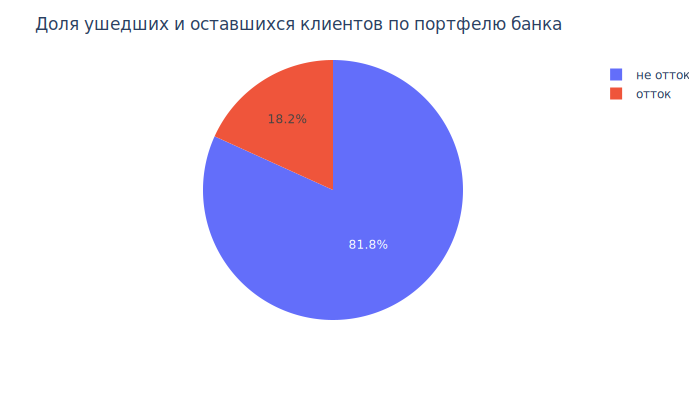

In [43]:
fig = px.pie(df['customer_churn'], names='customer_churn')

fig.update_layout(title='Доля ушедших и оставшихся клиентов по портфелю банка',
                 width=700,
                 height=400)

fig.show('svg')

По всему банку доля оттока - 18.2%, оставшиеся клиенты - 81.8%.

### Создание функций

**Для непрерывных признаков**

Создадим функцию, которая по признаку будет выводить описательную статистику и график ящик с усами для оттока и оставшихся клиентов.  
В качестве параметра используется рассматриваемый признак.

In [44]:
def desсribe_attribute(attribute):
    
    # описательная статистика
    print('Описательная статистика для оттока:', 
          round(df.query('churn == 1')[attribute].describe())
         )
    print('')
    print('Описательная статистика для лояльных клиентов:', 
          round(df.query('churn == 0')[attribute].describe())
         )
    
    # ящик с усами
    plt.figure(figsize=(15,2))
    sns.boxplot(x=attribute, y = 'customer_churn', data=df)

    plt.title('Распределение значений {}'.format(attribute), fontsize=20, fontweight="bold")
    plt.xlabel('{}'.format(attribute), fontsize=14, fontweight="bold")
    plt.ylabel('', fontsize=14, fontweight="bold");
    plt.show();

Создадим функцию, которая будет выводить гистограмму распределения по ушедшим и лояльным клиентам банка.
В качестве параметров используются:
- рассматриваемый признак (attribute)
- минимальное значение признака (x_min)
- максимальное значение признака (x_max), используется для ограничения значений, чтобы избежать  редких значений
- количество корзин (bins)

In [45]:
def hist_attribute(attribute, x_min, x_max, bins):
    
    fig = px.histogram(
    df, 
    x=attribute,
    range_x=[x_min, x_max], 
    color='customer_churn',
    nbins= bins, 
    histnorm='probability', 
    barmode = 'overlay',
    title='Распределение по {}'.format(attribute),
    )

    fig.update_xaxes(title_text='{}'.format(attribute)) 
    fig.update_yaxes(title_text='Частота') 

    fig.show('svg')

Создадим функцию, которая будет определять долю оттока для интевала [min_value, max_value] по рассматриваемому признаку и сравнивать с показателем оттока по банку.

В качестве параметров используются:
- рассматриваемый признак (attribute)
- минимальное значение параметра (min_value)
- максимальное значение параметра (max_value)  

Интервал [min_value, max_value] выбирается исходя из анализа гистограммы распределения ушедших и лояльных клиентов.

In [46]:
def churn_rate_attribute(atribute, min_value, max_value):
    
    # определяется отток по признаку
    churn_rate_atr = round(
        len(df.loc[(df['churn'] == 1) & (df[atribute] >= min_value) & (df[atribute] <= max_value)]) / 
        len(df.loc[(df[atribute] >= min_value) & (df[atribute] <= max_value)])
        , 2
    )
    print('Доля оттока клиентов составляет', churn_rate_atr)
    print('')
    
    # сравнение оттока по признаку с оттоком по банку
    if churn_rate_bank < churn_rate_atr:
        print('Доля оттока по рассматриваемому признаку превышает долю оттока по банку на', \
              '{0:.0%}'.format(churn_rate_atr / churn_rate_bank - 1)
             )
    else:
        print('Доля оттока по рассматриваемому признаку не превышает долю оттока по банку') 

**Для дискретных и категориальных признаков**

Создадим функцию, которая будет:
- определять коэффициенты оттока по дискретным или кодированным признакам
- определять превышает ли значение коэффициента оттока по признаку показатель оттока по банку, если превышает на сколько %%
- строить график оттока по признаку, значения на графике будут сравниваться с коэффициентом оттока по банку.  
В качестве входящего параметра передается признак.

In [47]:
def discrete_churn(attribute):
    
    # создаем дф с определением коэффициентов оттока по признаку
    churn_attr = df.query('churn == 1')[attribute].value_counts() / df[attribute].value_counts()
    print('Коэффициенты оттока {}:'.format(attribute) + '\n',  round(churn_attr, 3))
    print()
    
    # сбрасываем индексы и переименовываем столбцы
    churn_attr = churn_attr.reset_index()
    churn_attr.columns = ['attribute', 'churn_rate']
    
    # сравниваем отток по признаку с оттоком по банку
    for i in churn_attr.index:
        if churn_attr['churn_rate'][i] > churn_rate_bank:
            print('Превышение показателя оттока по банку', churn_attr['attribute'][i], \
                  '{0:.1%}'.format(churn_attr['churn_rate'][i] / churn_rate_bank-1))
        
    # выводим график
    plt.figure(figsize=(15,7))
    sns.barplot(data = df, x= attribute, y = 'churn', ci= None)
    plt.axhline(y=churn_rate_bank, linewidth=1, color='r', zorder=1)

    plt.title('График оттока по {}'.format(attribute), fontsize=20, fontweight="bold")
    plt.xlabel('{}'.format(attribute), fontsize=14, fontweight="bold")
    plt.ylabel('Коэффициент оттока', fontsize=14, fontweight="bold");

### Анализ оттока клиентов в разрезе баллов кредитного скоринга

**Посмотрим описательную статистику и распределение выборки для score.**

Описательная статистика для оттока: count    1818.0
mean      863.0
std        50.0
min       706.0
25%       828.0
50%       866.0
75%       898.0
max      1000.0
Name: score, dtype: float64

Описательная статистика для лояльных клиентов: count    8155.0
mean      845.0
std        68.0
min       642.0
25%       796.0
50%       848.0
75%       900.0
max      1000.0
Name: score, dtype: float64


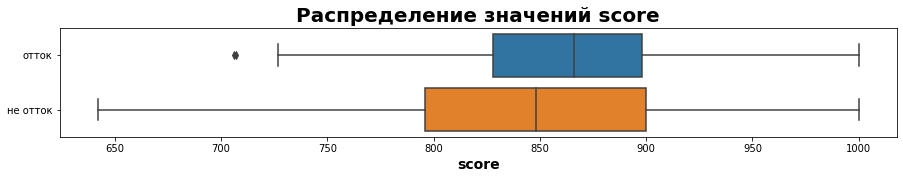

In [48]:
desсribe_attribute('score')

У ушедших клиентов несущественно выше показатели по баллам кредитного скорринга.  
Возможно, это обусловлено существенным различием в размерах выборок (оставшиеся клиены более чем в 4 раза превышают ушедших).

**Построим график распределения ушедших и оставшихся клиентов в зависимости от баллов скорринга.**

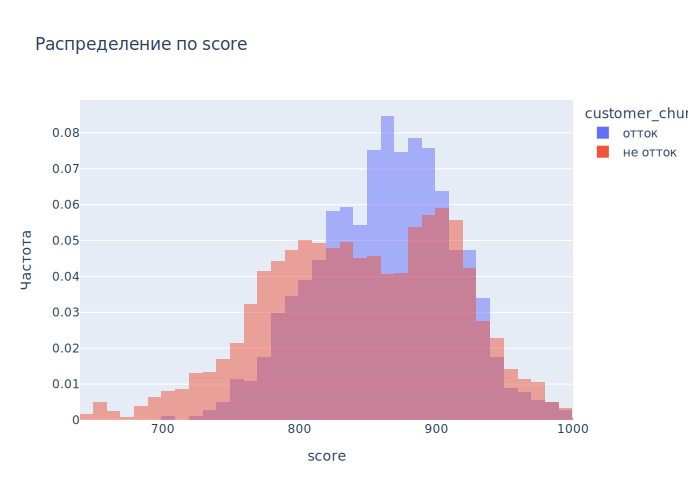

In [49]:
hist_attribute('score', 640, 1000, 50)

Удельный вес ушедших клиентов с высокими баллами скорринга (от 820 до 939) превышает удельный вес оставшихся клиентов. 

Определим долю ушедших клиентов с баллами скорринга в диапазоне от 820 до 939 (включительно) балов и сравним с оттоком клиентов по банку.

In [50]:
churn_rate_attribute('score', 820, 939)

Доля оттока клиентов составляет 0.23

Доля оттока по рассматриваемому признаку превышает долю оттока по банку на 26%


**Отток клиентов с баллами скорринга от 820 до 939 составляет 23%, что превышает уровень оттока клиентов по банку на 26%.**

### Анализ оттока клиентов в разрезе города

Определим показатель оттока по городам.

Коэффициенты оттока city:
 Ярославль    0.190
Рыбинск      0.163
Ростов       0.187
Name: city, dtype: float64

Превышение показателя оттока по банку Ярославль 4.5%
Превышение показателя оттока по банку Ростов 2.8%


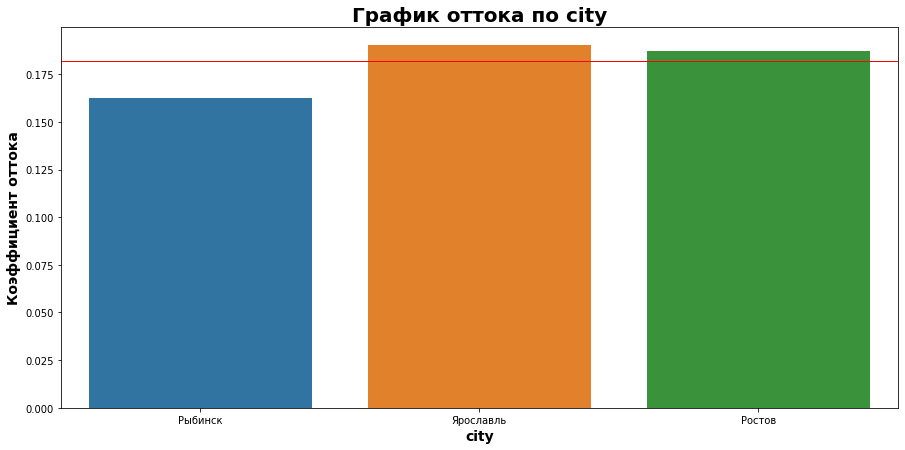

In [51]:
discrete_churn('city')

**В Ярославле и Ростове показатель оттока клиентов составляет 19% и 18.7%, что превышает показатель оттока по банку на 4.5% и 2.8% соответственно.**

### Анализ оттока клиентов в разрезе пола

Коэффициенты оттока gender:
 мужской    0.237
женский    0.127
Name: gender, dtype: float64

Превышение показателя оттока по банку мужской 30.2%


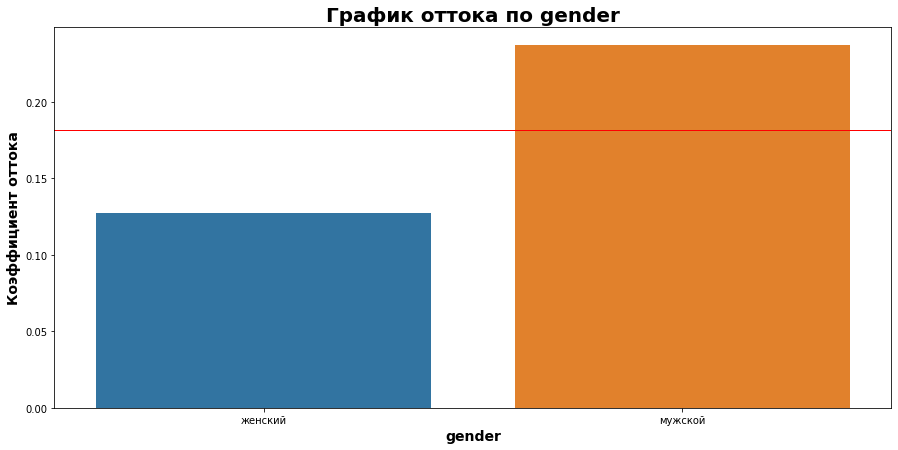

In [52]:
discrete_churn('gender')

**Отток клиентов мужского пола составляет 23.7%, что превышает показатель по банку на 30.2%.**

### Анализ оттока клиентов в разрезе возраста

Посмотрим описательную статистику и распределение выборки.

Описательная статистика для оттока: count    1818.0
mean       41.0
std        11.0
min        18.0
25%        32.0
50%        39.0
75%        52.0
max        75.0
Name: age, dtype: float64

Описательная статистика для лояльных клиентов: count    8155.0
mean       43.0
std        12.0
min        18.0
25%        34.0
50%        40.0
75%        51.0
max        86.0
Name: age, dtype: float64


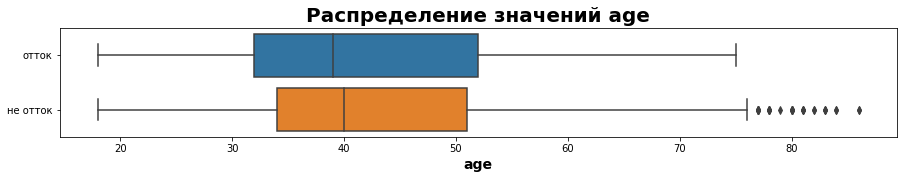

In [53]:
desсribe_attribute('age')

Описательная статистика и график ящик с усами не показывают существенного различия в возрасте ушедших и оставшихся клиентов в банке.

Построим график распределения ушедших и оставшихся клиентов в зависимости от возраста.

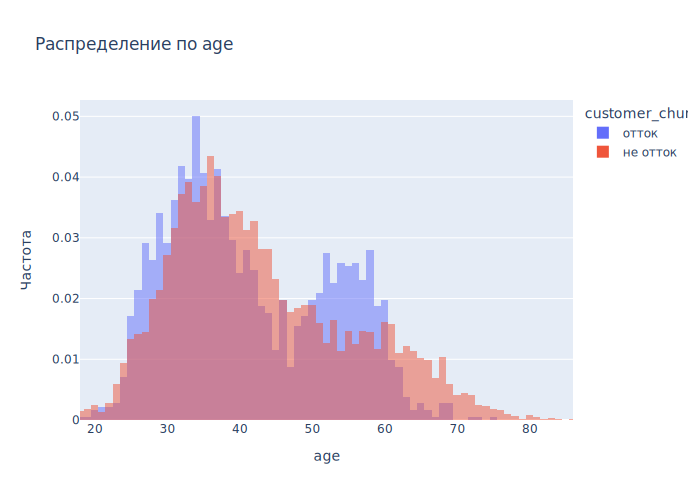

In [54]:
hist_attribute('age', 18, 86, 100)

Выделяются два интервала, для которых характерно - ушедшие клиенты превышает лояльных клиентов:
- от 25 до 35 лет
- от 50 до 60 года

Определим долю ушедших клиентов на выявленных интервалах и сравним с оттоком клиентов по банку.

In [55]:
churn_rate_attribute('age', 25, 35)

Доля оттока клиентов составляет 0.22

Доля оттока по рассматриваемому признаку превышает долю оттока по банку на 21%


In [56]:
churn_rate_attribute('age', 50, 60)

Доля оттока клиентов составляет 0.26

Доля оттока по рассматриваемому признаку превышает долю оттока по банку на 43%


**Отток клиентов по возрасту:**  
**- от 25 до 35 лет составляет 22%, что превышает показатель по банку на 21%**  
**- от 50 до 60 лет составляет 26%, что превышает показатель по банку на 43%**

### Анализ оттока клиентов в разрезе баллов собственности

Коэффициенты оттока equity:
 0    0.035
1    0.120
2    0.158
3    0.208
4    0.251
5    0.301
6    0.360
7    0.462
8    0.353
9    0.538
Name: equity, dtype: float64

Превышение показателя оттока по банку 3 14.5%
Превышение показателя оттока по банку 4 38.0%
Превышение показателя оттока по банку 5 65.3%
Превышение показателя оттока по банку 6 97.9%
Превышение показателя оттока по банку 7 154.1%
Превышение показателя оттока по банку 8 93.9%
Превышение показателя оттока по банку 9 195.9%


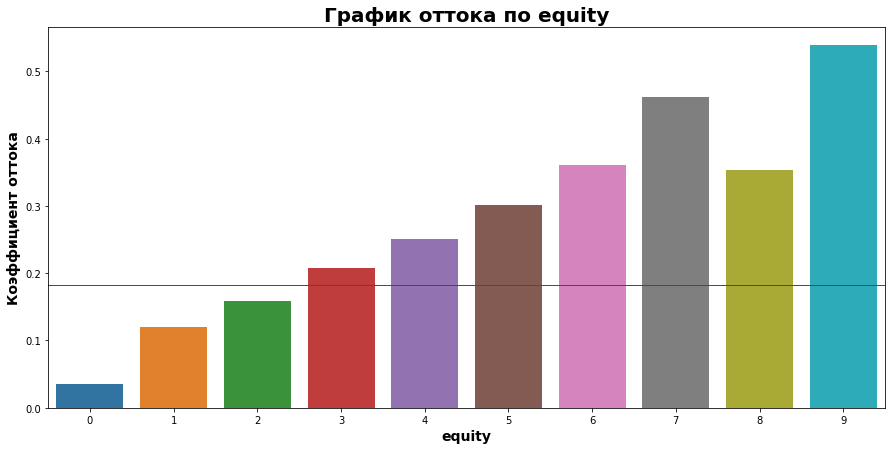

In [57]:
discrete_churn('equity')

**Отток клиентов, у которых в собственности находятся более 2-х единиц имущества, превышает показатель оттока по банку (существенное превышение начинается у клиентов с собственностью более 3 ед. имущества).**

### Анализ оттока клиентов в разрезе баланса

Посмотрим описательную статистику и распределение выборки.

Описательная статистика для оттока: count        1806.0
mean      1134458.0
std       2034446.0
min             6.0
25%        387482.0
50%        783909.0
75%       1348128.0
max      64866210.0
Name: balance, dtype: float64

Описательная статистика для лояльных клиентов: count         5889.0
mean        733032.0
std        1953952.0
min              0.0
25%         279655.0
50%         475410.0
75%         853826.0
max      119113552.0
Name: balance, dtype: float64


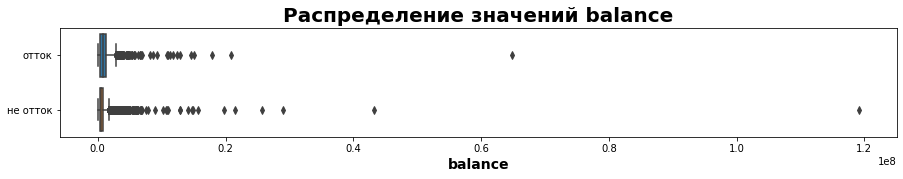

In [58]:
desсribe_attribute('balance')

В балансах ушедших клиентов и лояльных банку наблюдаются различия:  
- среднее значение у оттока - 1,13 млн., у лояльных - 0,73 млн.  
- медиана у оттока - 0,78 млн., у лояльных - 0,47 млн.

Построим график распределения ушедших и оставшихся клиентов в зависимости от баланса.  
На гистограмме отобразим клиентов с балансом до 6 млн., поскольку клиенты с большим балансом в банке встречаются редко.

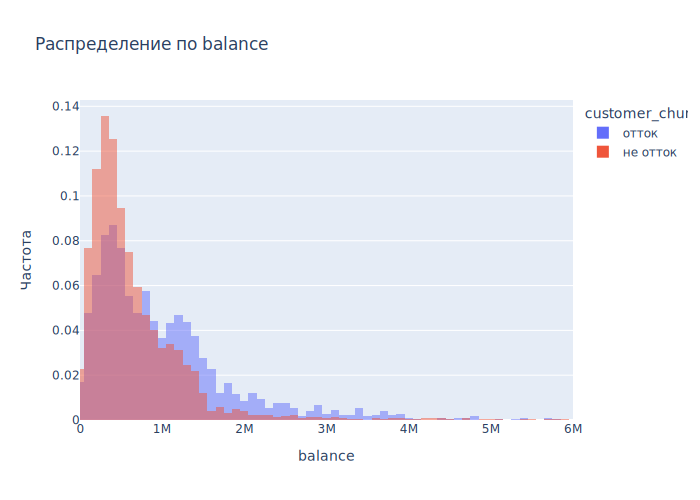

In [59]:
hist_attribute('balance', 0, 6000000, 1500)

Клиенты с большим балансом (от 750 тыс.) склонны к оттоку.

Определим долю ушедших клиентов на выявленных интервалах и сравним с оттоком клиентов по банку.

In [60]:
churn_rate_attribute('balance', 750000, 150000000)

Доля оттока клиентов составляет 0.35

Доля оттока по рассматриваемому признаку превышает долю оттока по банку на 92%


**Отток клиентов с балансом свыше 750тыс. составляет 35%, что превышает показатель по банку на 92%.**

### Анализ оттока клиентов в разрезе оформленных продуктов

Коэффициенты оттока products:
 1    0.071
2    0.191
3    0.286
4    0.633
5    0.421
Name: products, dtype: float64

Превышение показателя оттока по банку 2 5.0%
Превышение показателя оттока по банку 3 57.2%
Превышение показателя оттока по банку 4 247.8%
Превышение показателя оттока по банку 5 131.3%


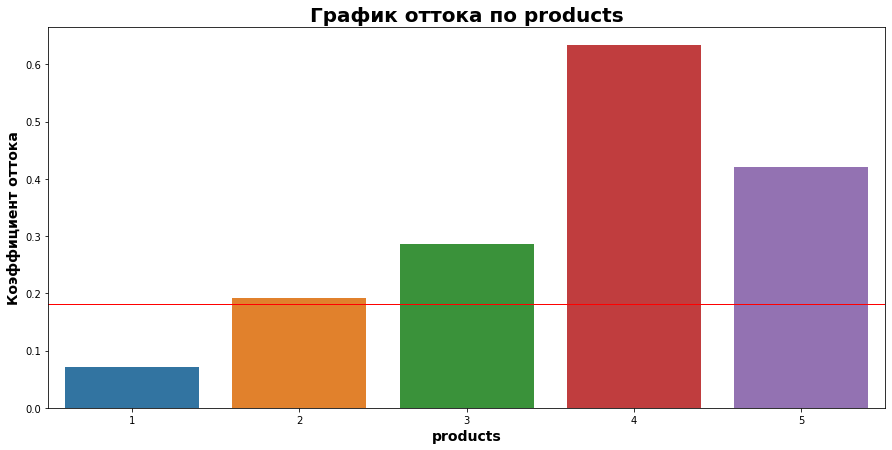

In [61]:
discrete_churn('products')

**Отток клиентов, у которых оформлено более 2-х продуктов варьируется от 7% до 63% и превышает показатель оттока по банку в зависимости от количества оформленных продуктов на 5-247%%(существенное превышение начинается если в собственности более 3-х продуктов).**

### Анализ оттока клиентов в разрезе кредитных карт

Коэффициенты оттока cred_card:
 оформлена       0.148
не оформлена    0.256
Name: cred_card, dtype: float64

Превышение показателя оттока по банку не оформлена 40.4%


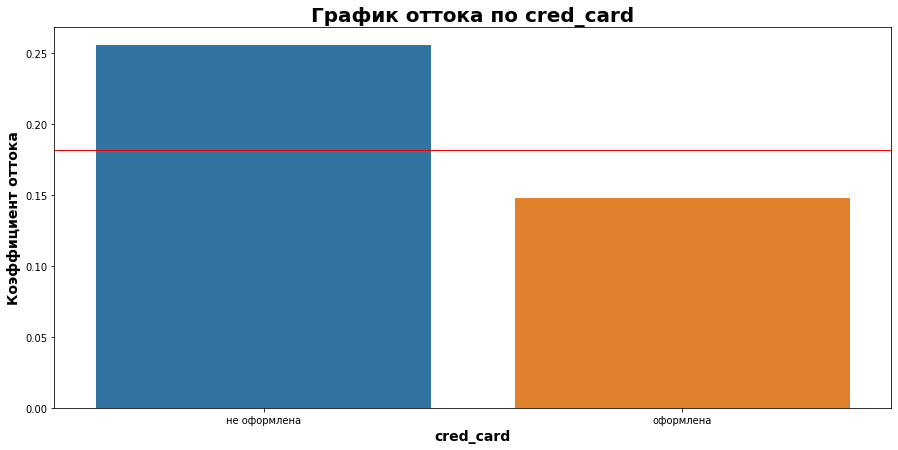

In [62]:
discrete_churn('cred_card')

**Отток клиентов без кредитных карт составляет 25.6%, что превышает банковский показатель на 40.4%.**

### Анализ оттока клиентов в разрезе активности

Коэффициенты оттока activity:
 активный       0.245
не активный    0.114
Name: activity, dtype: float64

Превышение показателя оттока по банку активный 34.5%


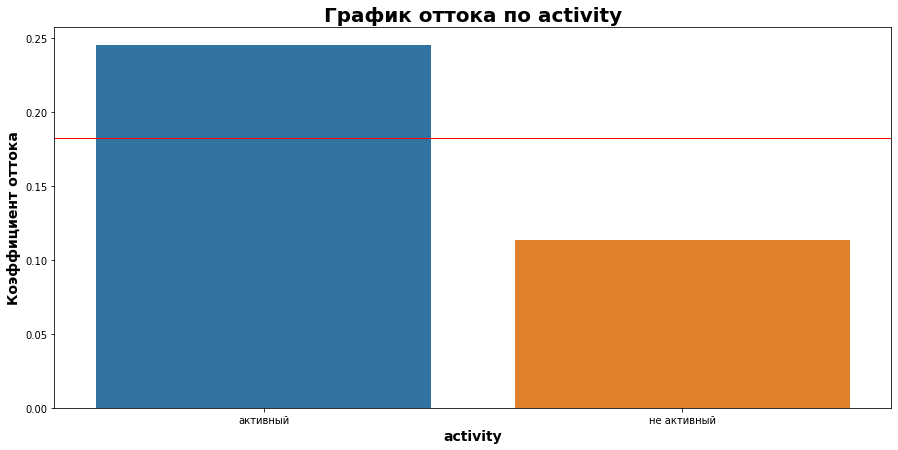

In [63]:
discrete_churn('activity')

**Отток 'активных' клиентов составляет 24.5%, что превышает банковский показатель на 34.5%.**

### Анализ оттока клиентов в разрезе доходов

Посмотрим описательную статистику и распределение выборки.

Описательная статистика для оттока: count       1818.0
mean      148357.0
std       122932.0
min        10880.0
25%        83286.0
50%       125409.0
75%       176018.0
max      1263028.0
Name: est_salary, dtype: float64

Описательная статистика для лояльных клиентов: count       8155.0
mean      147675.0
std       142684.0
min         2546.0
25%        73446.0
50%       118228.0
75%       173961.0
max      1395064.0
Name: est_salary, dtype: float64


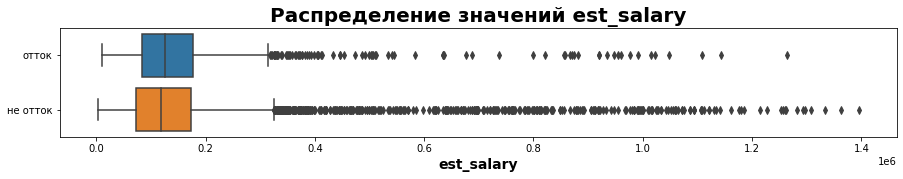

In [64]:
desсribe_attribute('est_salary')

Существенных различий по доходам у ушедших и лояльных клиентов не наблюдается.

Среднее значение дохода у ушедших - 148.3тыс., у оставшихся - 147.6 тыс.  
Медиана дохода у ушедших - 125.4тыс., у оставшихся - 118.2 тыс.

Построим график распределения ушедших и оставшихся клиентов в разрезе по доходам.  

На гистограмме отобразим клиентов с доходом до 600 тыс., поскольку клиенты с большим доходов в банке встречаются редко.

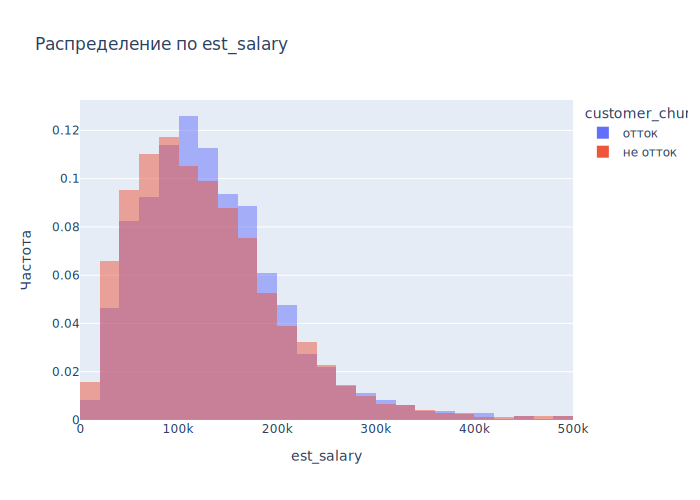

In [65]:
hist_attribute('est_salary', 0, 500000, 100)

Клиенты с доходом от 100 тыс. до 220 тыс. более склонны к оттоку.

Определим долю ушедших клиентов на выявленных интервалах и сравним с оттоком клиентов по банку.

In [66]:
churn_rate_attribute('est_salary', 100000, 220000)

Доля оттока клиентов составляет 0.2

Доля оттока по рассматриваемому признаку превышает долю оттока по банку на 10%


**Отток клиентов с доходом от 100тыс. до 220тыс. составляет 20%, что превышает показатель по банку на 10%.**

### Исследование корреляции между признаками

#### Матрица и график матрицы корреляции по всем признакам дф.

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,1.00,0.09,0.07,0.04,0.53,0.17,0.42,0.21,0.05,0.40,0.23
city,0.09,1.00,0.01,0.09,0.06,0.04,0.13,0.07,0.03,0.17,0.02
gender,0.07,0.01,1.00,0.29,0.06,0.05,0.07,0.20,0.01,0.14,0.22
age,0.04,0.09,0.29,1.00,0.04,0.02,0.14,0.16,0.09,0.36,0.18
equity,0.53,0.06,0.06,0.04,1.00,0.00,0.58,0.22,0.05,0.29,0.35
balance,0.17,0.04,0.05,0.02,0.00,1.00,0.00,0.00,0.00,0.37,0.02
products,0.42,0.13,0.07,0.14,0.58,0.00,1.00,0.27,0.11,0.22,0.26
credit_card,0.21,0.07,0.20,0.16,0.22,0.00,0.27,1.00,0.05,0.04,0.20
last_activity,0.05,0.03,0.01,0.09,0.05,0.00,0.11,0.05,1.00,0.04,0.26
est_salary,0.40,0.17,0.14,0.36,0.29,0.37,0.22,0.04,0.04,1.00,0.05


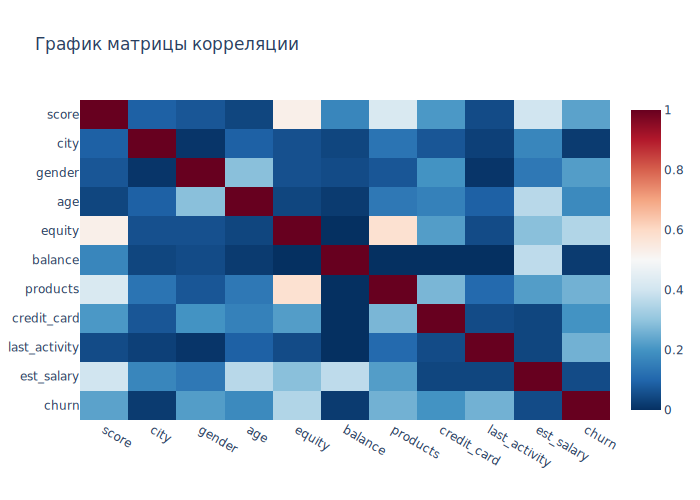

In [67]:
corr_df = round(
    df
    [
        [
            'score', 
            'city', 
            'gender', 
            'age', 
            'equity', 
            'balance', 
            'products', 
            'credit_card', 
            'last_activity', 
            'est_salary', 
            'churn'
        ]
    ]
    .phik_matrix(interval_cols = ['age', 'balance', 'est_salary', 'score'])
    , 2
)

display(corr_df)

fig = px.imshow(corr_df, aspect="auto", color_continuous_scale='RdBu_r', 
                title='График матрицы корреляции')
fig.show('svg')

По результатам анализа матрицы корреляций по всему датафрейму выявлена заметная корреляция между баллами кредитного скорринга и баллами собственности, а также между оформленными продуктами и и баллами собственности

В разрезе оттока клиентов умеренная корреляция между баллами собственности

#### Матрица и график матрицы корреляции по всем признакам дф в разрезе оттока.

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary
score,1.00,0.08,0.08,0.29,0.45,0.46,0.34,0.30,0.28,0.48
city,0.08,1.00,0.02,0.12,0.04,0.02,0.17,0.04,0.03,0.12
gender,0.08,0.02,1.00,0.17,0.00,0.00,0.06,0.26,0.23,0.00
age,0.29,0.12,0.17,1.00,0.17,0.00,0.22,0.09,0.19,0.39
equity,0.45,0.04,0.00,0.17,1.00,0.00,0.24,0.19,0.15,0.09
balance,0.46,0.02,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.70
products,0.34,0.17,0.06,0.22,0.24,0.00,1.00,0.32,0.10,0.14
credit_card,0.30,0.04,0.26,0.09,0.19,0.00,0.32,1.00,0.14,0.07
last_activity,0.28,0.03,0.23,0.19,0.15,0.00,0.10,0.14,1.00,0.06
est_salary,0.48,0.12,0.00,0.39,0.09,0.70,0.14,0.07,0.06,1.00


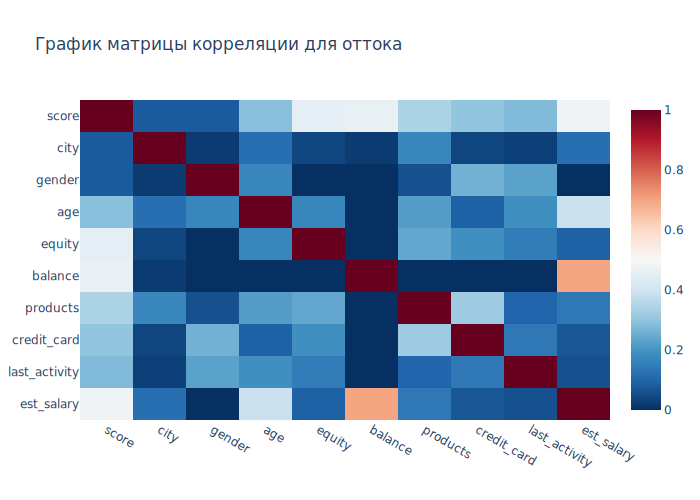

In [68]:
corr_df_churn = round(
    df.query('churn == 1')
    [
        [
            'score', 
            'city', 
            'gender', 
            'age', 
            'equity', 
            'balance', 
            'products', 
            'credit_card', 
            'last_activity', 
            'est_salary', 
            #'churn'
        ]
    ]
    .phik_matrix(interval_cols = ['age', 'balance', 'est_salary', 'score'])
    , 2
)

display(corr_df_churn)

fig = px.imshow(corr_df_churn, aspect="auto", color_continuous_scale='RdBu_r', 
                title='График матрицы корреляции для оттока')
fig.show('svg')

По результатам анализа матрицы корреляций для ушедших клиентов выявлена высокая корреляция для баланса и дохода 

### Портрет клиента в разрезе оттока 

Сгруппируем данные в разрезе отток/не отток по дискретным и категориальным признакам и определим моду.

In [69]:
df_gr_mode = (
    df
    .groupby('customer_churn')
    [
        [
            'city', 
            'gender',
            'equity',
            'products',
            'cred_card',
            'activity'
        ]
    ]
    .agg(pd.Series.mode)
    .reset_index(drop=True)
    .T
    .reset_index()
    .rename(columns = {'index':'attribute',  0:'not_churn', 1:'churn'})
)
df_gr_mode

,attribute,not_churn,churn
0,city,Ярославль,Ярославль
1,gender,женский,мужской
2,equity,0,5
3,products,2,2
4,cred_card,оформлена,оформлена
5,activity,не активный,активный


Создадаим сводную таблицу в разрезе отток/ не отток по непрерывным признакам, определим среднее и рассчитаем относительную разницу.

In [70]:
df_gr_mean = (
    df
    .pivot_table(
        index='customer_churn', 
        values=
        [
            'balance', 
            'est_salary', 
            'score', 
            'age'            
        ]
        , aggfunc=
        {
            'balance':'mean',
            'est_salary':'mean',
            'score':'mean',
            'age':'mean'                
        }
    )
    .reset_index(drop=True)
    .T
    .reset_index()
    .rename(columns = {'index':'attribute',  0:'not_churn', 1:'churn'})
)
df_gr_mean = round(df_gr_mean)
df_gr_mean['relative_diff'] = round(df_gr_mean['churn'] / df_gr_mean['not_churn'], 2)
df_gr_mean

,attribute,not_churn,churn,relative_diff
0,age,43.0,41.0,0.95
1,balance,733032.0,1134458.0,1.55
2,est_salary,147675.0,148357.0,1.00
3,score,845.0,863.0,1.02


Для признаков, у которых много редких значений посчитаем медиану, чтобы посмотреть ассиметрию распределений.

In [71]:
df_gr_median = (
    df
    .pivot_table(
        index='customer_churn', 
        values=
        [
            'balance', 
            'est_salary', 
            #'score', 
            #'age'            
        ]
        , aggfunc=
        {
            'balance':['mean','median'],
            'est_salary':['mean','median'],
            #'score':'median',
            #'age':'mean'                
        }
    )
    .reset_index(drop=True)
)    
df_gr_median = round(df_gr_median)
df_gr_median

balance           est_salary          
        mean    median       mean    median
0   733032.0  475410.0   147675.0  118228.0
1  1134458.0  783909.0   148357.0  125409.0

Средние значения balance и est_salary больше, чем медиана, значит распределение ассимитрично вправо.

Объединим полученные таблицы.

In [72]:
customer_profile = pd.concat([df_gr_mean,df_gr_mode], ignore_index= True ).fillna('-')
customer_profile

,attribute,not_churn,churn,relative_diff
0,age,43.0,41.0,0.95
1,balance,733032.0,1134458.0,1.55
2,est_salary,147675.0,148357.0,1.0
3,score,845.0,863.0,1.02
4,city,Ярославль,Ярославль,-
5,gender,женский,мужской,-
6,equity,0,5,-
7,products,2,2,-
8,cred_card,оформлена,оформлена,-
9,activity,не активный,активный,-


Для клиентов, покинувших банк характерно:
- город Ярославль
- мужской пол
- баллы собственности - 5
- 2 оформленных продукта
- оформлена кредитная карта
- статус активный
- среднее значение баланса составляет 1,13 млн., что на 55% превышает значения лояльных клиентов
- среднее значение дохода составляет 148 тыс. практически не отличается от значения лояльных клиентов 
- среднее значение баллов скорринга составляет 863, что на 2% выше значения лояльных клиентов 
- средний возраст составляет 41 год, у лояльных 43. 

[в начало](#intro)

<a id='hypothesis'></a>
## Проверка статистических гипотез

1. Между ушедшими и оставшимися клиентами существует различие в доходах
2. Средний баланс у ушедших клиентов женского пола выше, чем у лояльных клиентов мужского
3. Средний балл скорринга у ушедших клиентов женского пола младше 35 лет (включительно) выше, чем у лояльных клиентов мужского пола возрастом старше 35 лет

### Между ушедшими и оставшимися клиентами существует различие в доходах

Сформулируем нулевую и альтернативную гипотезу:
- H0 - между ушедшими и оставшимися  клиентами доходы не различиаются
- Н1 - между ушедшими и оставшимися  клиентами доходы различиаются

Посмотрим размер выборок ушедших и лояльных клиентов.

In [73]:
print('размер выборки для оттока', len(df.query('churn == 1')))
print('размер выборки для оставшихся клиентов', len(df.query('churn == 0')))

размер выборки для оттока 1818
размер выборки для оставшихся клиентов 8155


Создадим функию сравнивающую дисперсию выборок ratio_var(selection1, selection2, n).  
В качестве параметров передаются сравниваемые выборки gen_pop1 и gen_pop2, n - вещественное число, с которым будет сравнение отшения дисперсий выборок - отклонение, при котором выборки будут считаться равными.

In [74]:
def ratio_var(selection1, selection2, n):
    if selection1.dropna().var() >= selection2.dropna().var():
        results =  (selection1.dropna().var() / selection2.dropna().var() - 1) * 100
    else:
        results = (selection2.dropna().var() / selection1.dropna().var() - 1) * 100
        
    if results < n:
        print('Отношение дисперсий выборок составляет', round(results, 2))
        print('В качестве параметра equal_var передается True')
    else:
        print('Отношение дисперсий выборок составляет', round(results, 2))
        print('В качестве параметра equal_var передается False')

Проверим равенство дисперсий выборок. 

In [75]:
ratio_var(
    df.query('churn == 1')['est_salary'], 
    df.query('churn == 0')['est_salary'], 
    0.05
         )

Отношение дисперсий выборок составляет 34.72
В качестве параметра equal_var передается False


Дисперсии выборок различаются.

Чтобы проверить гипотезу о равенстве среднего 2-х совокупностей применим метод scipy.stats.ttest_ind(), поскольку условия для проведения ttesta выполняются:
- генеральные совокупности не зависят друг от друга 
- выборочные средние нормально распределены (учитывая размеры выборок и ЦПТ)

В качестве параметра equal_var передадим False, поскольку дисперсия и размеры выборок различаются.  
Уровень значимости зададим равным 5%.

In [76]:
alpha = .05

results = st.ttest_ind(
    df.query('churn == 1')['est_salary'].dropna(), 
    df.query('churn == 0')['est_salary'].dropna(),
    equal_var = False
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.8354803526840116
Не получилось отвергнуть нулевую гипотезу


**Полученное p-значение больше уровня значимости, следовательно нет оснований отвергнуть нулевую гипотезу, т.е. значимого расхождения между средними доходами ушедших и лояльных клиентов не выявлено.**  

**Таким образом, средние доходы ушедших и лояльных клиентов могут быть одинаковыми, либо не достаточно данных для доказательств того, что средние доходы различаются.**

**Результаты проведенного t-теста показывают не обоснованность утверждения, сформулированного в гипотезе о различии в доходах.**

### Средний баланс у ушедших клиентов женского пола выше, чем у лояльных клиентов мужского пола 

Сформулируем нулевую и альтернативную гипотезу:
- H0 - средний балланс между ушедшими клиентами женского пола и лояльными клиентами мужского пола не различаются
- Н1 - средний балланс у ушедших клиентов женского пола выше и чем у лояльных клиентов мужского

Посмотрим размер выборок ушедших клиентов и мужского пола и лояльных клиентов женского пола.

In [77]:
print(len(df.query('churn == 1 and gender == "женский"')['balance']))
print(len(df.query('churn == 0 and gender == "мужской"')['balance']))

635
3808


Проверим равенство дисперсий выборок. 

In [78]:
ratio_var(
    df.query('churn == 1 and gender == "женский"')['balance'], 
    df.query('churn == 0 and gender == "мужской"')['balance'], 
    0.05
         )

Отношение дисперсий выборок составляет 787.02
В качестве параметра equal_var передается False


Дисперсии выборок различаются.

Чтобы проверить гипотезу о равенстве среднего 2-х совокупностей применим метод scipy.stats.ttest_ind(), поскольку условия для проведения ttesta выполняются:
- генеральные совокупности не зависят друг от друга 
- выборочные средние нормально распределены (учитывая размеры выборок и ЦПТ)

В качестве параметра equal_var передадим False, поскольку дисперсия и размеры выборок различаются.  
Уровень значимости зададим равным 5%.

In [79]:
alpha = .05

results = st.ttest_ind(
    df.query('churn == 1 and gender == "женский"')['balance'].dropna(), 
    df.query('churn == 0 and gender == "мужской"')['balance'].dropna(),
    equal_var = False,
    alternative = 'greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0040340982510890565
Отвергаем нулевую гипотезу


**Полученное p-значение гораздо меньше уровня значимости, следовательно отвергаем нулевую гипотезу о равенстве средних двух генеральных совокупностей в пользу альтернативной гипотезы.**


**Таким образом, у ушедших клиентов женского пола средний баланс выше, чем у лояльных клиентов мужского.**

**Таким образом, результаты проведенного t-теста показывают на обоснованность утверждения, сформулированного в гипотезе о различии в балансах.**

### Средний балл скорринга у ушедших клиентов женского пола младше 35 лет (включительно) выше, чем у лояльных клиентов мужского пола возрастом старше 35 лет

Сформулируем нулевую и альтернативную гипотезу:
- H0 - средний балл скорринга между ушедшими клиентами женского пола до 35 лет (включительно) и лояльными клиентами мужского пола старше 35 лет не различиается
- Н1 - средний балл скорринга у ушедших клиентов женского пола до 35 лет (включительно) выше чем у лояльных клиентов мужского пола старше 35 лет

Посмотрим размер выборок.

In [80]:
print(len(df.query('churn == 0 and gender == "женский" and age <= 35')['score']))
print(len(df.query('churn == 1 and gender == "мужской" and age > 35')['score']))

1149
704


Проверим равенство дисперсий выборок.

In [81]:
ratio_var(
    df.query('churn == 0 and gender == "женский" and age <= 35')['score'], 
    df.query('churn == 1 and gender == "мужской" and age > 35')['score'], 
    0.05
         )

Отношение дисперсий выборок составляет 51.78
В качестве параметра equal_var передается False


Чтобы проверить гипотезу о равенстве среднего 2-х совокупностей применим метод scipy.stats.ttest_ind(), поскольку условия для проведения ttesta выполняются:
- генеральные совокупности не зависят друг от друга 
- выборочные средние нормально распределены (учитывая размеры выборок и ЦПТ)

В качестве параметра equal_var передадим False, поскольку дисперсия и размеры выборок различаются.  
Уровень значимости зададим равным 5%.

In [82]:
alpha = .05

results = st.ttest_ind(
    df.query('churn == 1 and gender == "женский" and age <= 35')['score'].dropna(), 
    df.query('churn == 0 and gender == "мужской" and age > 35')['score'].dropna(),
    equal_var = False,
    alternative = 'greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.059772170124498e-24
Отвергаем нулевую гипотезу


**Полученное p-значение гораздо меньше уровня значимости, следовательно отвергаем нулевую гипотезу о равенстве средних двух генеральных совокупностей в пользу альтернативной гипотезы.**  

**Это означает, что средний балл у ушедших клиентов женского пола до 35 лет (включительно) выше чем у лояльных клиентов мужского пола старше 35 лет.**

**Таким образом, результаты проведенного t-теста показывают на обоснованность утверждения, сформулированного в гипотезе о различии в баллах скоринга.**

[в начало](#intro)

## Промежуточный вывод

**Коэффициент оттока клиентов по всему банку составляет 18.2%.**

**Отток клиентов в разрезе по признакам:**
- отток клиентов с баллами скорринга от 820 до 939 составляет 23%, что превышает уровень оттока клиентов по банку на 26%
- в Ярославле и Ростове показатель оттока клиентов составляет 19.1% и 18.7%, что превышает показатель оттока по банку на 4.5% и 2.8% соответственно
- отток клиентов мужского пола составляет 23.7%, что превышает показатель по банку на 30.2%.
- отток клиентов по возрасту:
  - от 25 до 35 лет составляет 22%, что превышает показатель по банку на 21%
  - от 50 до 60 лет составляет 26%, что превышает показатель по банку на 43%
- отток клиентов, у которых в собственности находятся более 2-х единиц имущества, превышает показатель оттока по банку (существенное превышение начинается у клиентов с собственностью более 3 ед. имущества)
- отток клиентов с балансом свыше 750тыс. составляет 35%, что превышает показатель по банку на 92%
- отток клиентов, у которых оформлено более 2-х продуктов варьируется от 7% до 63% и превышает показатель оттока по банку в зависимости от количества оформленных продуктов на 5-247%%(существенное превышение начинается если в собственности более 3-х продуктов).
- отток клиентов без кредитных карт составляет 25.6%, что превышает банковский показатель на 40.4%.
- отток 'активных' клиентов составляет 24.5%, что превышает банковский показатель на 34.5%.
- отток клиентов с доходом от 100тыс. до 220тыс. составляет 20%, что превышает показатель по банку на 10%.

По результатам анализа матрицы корреляций по всему датафрейму выявлена заметная корреляция между баллами кредитного скорринга и баллами собственности, а также между оформленными продуктами и и баллами собственности.
В разрезе оттока клиентов умеренная корреляция между баллами собственности.

По результатам анализа матрицы корреляций для ушедших клиентов выявлена высокая корреляция для баланса и дохода.


**Портрет клиента, наиболее склонного к оттоку:**
- город Ярославль
- мужской пол
- баллы собственности - 5
- 2 оформленных продукта
- оформлена кредитная карта
- статус активный
- среднее значение баланса составляет 1,13 млн., что на 55% выше значения лояльных клиентов
- среднее значение дохода составляет ~ 148 тыс.практически не отличается от значения лояльных клиентов
- среднее значение баллов скорринга составляет 863, что на 2% выше значения лояльных клиентов
- средний возраст составляет 41 год, у лояльных 43.

**Проверены гипотезы:**

- результаты проведенного t-теста показывают не обоснованность утверждения, сформулированного в гипотезе 'между ушедшими и оставшимися клиентами существует различие в доходах'. Гипотеза опровергнута, что означает значимого расхождения между средними доходами ушедших и лояльных клиентов не выявлено. Таким образом, средние доходы ушедших и лояльных клиентов могут быть одинаковыми, либо не достаточно данных для доказательств того, что средние доходы различаются.

- результаты проведенного t-теста показывают обоснованность утверждения, сформулированного в гипотезе 'средний баланс у ушедших клиентов женского пола выше, чем у лояльных клиентов мужского', поскольку гипотеза о равенстве средних значений была отвергнута в пользу альтернативной гипотезы. Таким образом, у ушедших клиентов женского пола средний баланс выше, чем у лояльных клиентов мужского.

- результаты проведенного t-теста показывают обоснованность утверждения, сформулированного в гипотезе 'средний балл скорринга у ушедших клиентов женского пола младше 35 лет (включительно) выше, чем у лояльных клиентов мужского пола возрастом старше 35 лет', поскольку гипотеза о равенстве средних значений была отвергнута в пользу альтернативной гипотезы. Таким образом, средний балл у ушедших клиентов женского пола до 35 лет (включительно) выше, чем у лояльных клиентов мужского пола старше 35 лет.

[в начало](#intro)

<a id='segmentation'></a>
## Сегментация

Проведем сегментацию признаков по интервалам значений признака, наиболее склонных к оттоку.

Создадим функцию сегментации признака по интервалу def seсtor(atribute, interval, min_value, max_value).  
Функции передаются параметры: признак, интервал признака (строчное выражение), минимальное значение интервала, максимальное значение интервала).  
Результатом будет дф из одной строки со значениями (наименование признака, интревал признака, размер сегмента, размер сегмента оттока, коэффициент оттока, отношение коэффициента оттока к показателю по банку).

In [83]:
def seсtor(atribute, interval, min_value, max_value):
    dict = {}
    dict['attribute'] = atribute
    dict['interval'] = interval
    dict['size_churn'] = len(df.loc[(df['churn'] == 1) & (df[atribute] >= min_value) & (df[atribute] <= max_value)])
    dict['size'] = len(df.loc[(df[atribute] >= min_value) & (df[atribute] <= max_value)])
    dict['churn_rate'] = round(dict['size_churn'] / dict['size'],2)
    dict['diff_%'] = round(100* (dict['churn_rate'] / churn_rate_bank - 1))
    ds = pd.DataFrame.from_dict(dict, orient='index').T
    ds = ds[['attribute', 'interval', 'size', 'size_churn', 'churn_rate', 'diff_%']]
    return ds

Создадим дф с сегментами по каждому признаку.  

In [84]:
score = seсtor('score', 'от 820 до 939', 820, 939)
balance = seсtor('balance', 'от 750тыс.', 750000, 150000000)
est_salary = seсtor('est_salary', 'от 100тыс. до 220тыс.', 100000, 220000)
age_30 = seсtor('age', 'от 25 до 35', 25, 35)
age_50 = seсtor('age', 'от 50 до 60', 50, 60)
products = seсtor('products', 'от 3 до 5', 3, 5)
equity = seсtor('equity', 'от 3 до 9', 3, 9)

seсtor_churn = pd.concat(
    [
        score,balance,
        est_salary, 
        age_30, age_50, 
        products, 
        equity
    ], 
    ignore_index= True
)

seсtor_churn.sort_values(by='diff_%', ascending=False, ignore_index = True)

,attribute,interval,size,size_churn,churn_rate,diff_%
0,products,от 3 до 5,1531,605,0.4,120
1,balance,от 750тыс.,2700,941,0.35,92
2,age,от 50 до 60,1768,468,0.26,43
3,equity,от 3 до 9,5573,1469,0.26,43
4,score,от 820 до 939,5980,1371,0.23,26
5,age,от 25 до 35,3055,665,0.22,21
6,est_salary,от 100тыс. до 220тыс.,4708,963,0.2,10


Определим 3 сегмента с более точными характеристиками, у которых размер более 500 и показатель оттока превышает банковский.

**Сегмент 1. Клиенты, баланс которых свыше 750000.**

In [85]:
seсtor('balance', 'от 750тыс.', 750000, 150000000)

,attribute,interval,size,size_churn,churn_rate,diff_%
0,balance,от 750тыс.,2700,941,0.35,92


**Сегмент 2. Клиенты, доход которых от 100тыс. до 220тыс. и баллы кредитного скорринга выше 820.**

In [86]:
print('размер сегмента', 
      len(df.query('churn == 1  & 100000 <= est_salary <= 220000 & score >= 820')) )
print('показатель оттока', 
      round(
          len(df.query('churn == 1  & 100000 <= est_salary <= 220000 & score >= 820 ')) / 
          len(df.query('100000 <= est_salary <= 220000 & score >= 820 '))
          ,2)
)
print('превышение показателя по банку', 
      round(
          len(df.query('churn == 1  & 100000 <= est_salary <= 220000 & score >= 820 ')) / 
          len(df.query('100000 <= est_salary <= 220000 & score >= 820 ')) / 
          churn_rate_bank
          ,2)
)

размер сегмента 808
показатель оттока 0.25
превышение показателя по банку 1.36


**Сегмент 3. Клиенты возрастом от 25 до 35 и статус активный**

In [87]:
print('размер сегмента', len(df.query('churn == 1  & 25 <= age <= 35 & last_activity == 1')))
print('показатель оттока',
      round(
          len(df.query('churn == 1  & 25 <= age <= 35 & last_activity == 1')) /
          len(df.query('25 <= age <= 35 & last_activity == 1'))
          ,2)
)
print('превышение показателя по банку',
      round(
          len(df.query('churn == 1  & 25 <= age <= 35 & last_activity == 1')) /
          len(df.query('25 <= age <= 35 & last_activity == 1'))/
          churn_rate_bank
          ,2)
)

размер сегмента 527
показатель оттока 0.32
превышение показателя по банку 1.75


# Приоритезация сегментов

Проранжируем сегменты по степени приоритезации в зависимости от показателя оттока.

1. Клиенты, баланс которых свыше 750000.
2. Клиенты возрастом от 25 до 35 и статус активный
3. Клиенты, доход которых от 100тыс. до 220тыс. и баллы кредитного скорринга выше 820.

[в начало](#intro)

<a id='conclusions'></a>
## Вывод

**По результатам исследования был составлен портрет клиентa в разрезе оттока:**
- город Ярославль
- мужской пол
- баллы собственности - 5
- 2 оформленных продукта
- оформлена кредитная карта
- статус активный
- среднее значение баланса составляет 1,13 млн., что на 55% выше значения лояльных клиентов
- среднее значение дохода составляет ~ 148 тыс. практически не отличается от значения лояльных клиентов
- среднее значение баллов скорринга составляет 863, что на 2% выше значения лояльных клиентов
- средний возраст составляет 41 год, у лояльных 43

**Были выявлены сегменты клиентов с коэффициентом оттока превышающим показатель оттока по банку:**
- products от 3 до 5 превышает на 120%
- balance от 750тыс. превышает на  92%
- age от 50 до 60 превышает на  43%
- equity от 3 до 9 превышает на 43%
- score от 820 до 939 превышает на 26%  
- age от 25 до 35 превышает на 21%  
- est_salaryот 100тыс. до 220тыс. превышает на 10%

**Проверка гипотез показала:**
- результаты проведенного t-теста показывают не обоснованность утверждения, сформулированного в гипотезе 'между ушедшими и оставшимися клиентами существует различие в доходах'. Гипотеза опровергнута, что означает значимого расхождения между средними доходами ушедших и лояльных клиентов не выявлено. Таким образом, средние доходы ушедших и лояльных клиентов могут быть одинаковыми, либо не достаточно данных для доказательств того, что средние доходы различаются.

- результаты проведенного t-теста показывают обоснованность утверждения, сформулированного в гипотезе 'средний баланс у ушедших клиентов женского пола выше, чем у лояльных клиентов мужского', поскольку гипотеза о равенстве средних значений была отвергнута в пользу альтернативной гипотезы. Таким образом, у ушедших клиентов женского пола средний баланс выше, чем у лояльных клиентов мужского.

- результаты проведенного t-теста показывают обоснованность утверждения, сформулированного в гипотезе 'средний балл скорринга у ушедших клиентов женского пола младше 35 лет (включительно) выше, чем у лояльных клиентов мужского пола возрастом старше 35 лет', поскольку гипотеза о равенстве средних значений была отвергнута в пользу альтернативной гипотезы. Таким образом, средний балл у ушедших клиентов женского пола до 35 лет (включительно) выше, чем у лояльных клиентов мужского пола старше 35 лет.

<a id='recommendations'></a>
## Рекомендации

Для клиентов, баланс которых свыше 750тыс.:
- увеличение %% ставок по банковским продуктам, либо приведение в соответствии с рыночными условиями
- повышение статуса клиента, с предоставлением положенных статусу услуг (персональный менеджер, доверительное управление и пр.)
- уменьшение спреда на покупку/продажу валюты

Для клиентов возрастом от 25 до 35 и статус активный
- введение кэшбеков на обучение, путешествия и развлечения
- изменение интерфейса приложения и интернет банка
- увеличение лимитов на банковские переводы

Для клиентов, доход которых от 100тыс. до 220тыс. и баллы кредитного скорринга выше 820:
- снижение ставок по кредитным продуктам либо приведение в соответствии с рыночными условиями
- выгодные программы рефинансирования задолженности других банков
- увеличение грейс-периода по кредитным картам

[в начало](#intro)